In [1]:
from collections import defaultdict, deque
import matplotlib.pyplot as plt
from string import ascii_lowercase
import imageio
from time import time

# 1. Zaimplementuj algorytm wyszukiwania wzorca 2-wymiarowego

#### Wyszukiwanie wzorca 1D (budowa automatu w czasie liniowym względem długości wzorca)

In [2]:
def transition_table(pattern):
    n = len(pattern)
    alphabet = set(pattern)
    transition = [defaultdict(lambda: 0) for _ in range(n + 1)]

    for i, pattern_letter in enumerate(pattern):
        prev = transition[i][pattern_letter]
        transition[i][pattern_letter] = i + 1
        for alphabet_letter in alphabet:
            transition[i + 1][alphabet_letter] = transition[prev][alphabet_letter]

    return transition


def automaton_pattern_matching(text, transition_tab):
    result = []

    q = 0
    m = len(transition_tab) - 1
    for i in range(0, len(text)):
        if text[i] in transition_tab[q]:
            q = transition_tab[q][text[i]]
            if q == m:
                result.append(i + 1 - q)
        else:
            q = 0

    return result

#### Implementacja budowy drzewa trie oraz funkcji zwracającej tablicę przejścia i stany akceptujące dla automatu wykrywającego wiele wzorców

In [3]:
class TrieNode:
    def __init__(self, node_id, letter="", parent=None):
        self.id = node_id
        self.letter = letter
        self.parent = parent
        self.terminal = False
        self.children = dict()

    def __str__(self):
        return f"TrieNode: letter={self.letter}, id={self.id}, terminal={self.terminal}, " \
               f"children={[(children.letter, children.id) for children in self.children.values()]}, " \
               f"parent_letter={self.parent.letter if self.parent is not None else 'NONE'}"


def build_trie(patterns):
    node_id = 0
    root = TrieNode(node_id, "root")
    nodes = [root]

    for pattern in patterns:
        node = root
        for letter in pattern:
            if letter in node.children:
                node = node.children[letter]
            else:
                node_id += 1
                new_node = TrieNode(node_id, letter, node)
                nodes.append(new_node)
                node.children[letter] = new_node
                node = new_node

        node.terminal = True

    return root, nodes


def print_trie(node):
    print(node)
    for children in node.children.values():
        print_trie(children)


def multi_patterns_transition_table(patterns, trie_print=False):
    trie, nodes = build_trie(patterns)

    alphabet = set()
    for pattern in patterns:
        alphabet.update(pattern)

    transition = [defaultdict(lambda: 0) for _ in range(len(nodes))]
    accept_states = []

    queue = deque(trie.children.values())
    while len(queue) > 0:
        node = queue.popleft()
        queue.extend(node.children.values())

        prev = transition[node.parent.id][node.letter]
        prev_node = nodes[prev]
        transition[node.parent.id][node.letter] = node.id

        if node.terminal or prev_node.terminal:
            accept_states.append(node.id)

        for letter in alphabet:
            if letter in prev_node.children:
                transition[node.id][letter] = prev_node.children[letter].id
            else:
                transition[node.id][letter] = transition[prev][letter]

    if trie_print:
        print_trie(trie)

    return transition, accept_states

#### Implementacja algorytmuu wyszukiwania wzorca 2-wymiarowego

In [4]:
def pattern_matching_2D(text, pattern_2d, split_lines=False, return_times=False):
    if split_lines:
        text = text.split("\n")

    patterns = [[] for _ in range(len(pattern_2d[0]))]
    for row in pattern_2d:
        for i, letter in enumerate(row):
            patterns[i].append(letter)

    start = time()
    transition, accept_states = multi_patterns_transition_table(patterns)
    transition_tab_construction_time = time() - start

    row_pattern = []
    for pattern in patterns:
        state = 0
        for letter in pattern:
            state = transition[state][letter]
        row_pattern.append(state)

    start = time()
    width, height = len(max(text, key=len)), len(text)
    states = [[0 for _ in range(len(line))] for line in text]

    for col in range(width):
        state = 0
        for row in range(height):
            if col < len(text[row]):
                letter = text[row][col]
                state = transition[state][letter]
                states[row][col] = state
            else:
                state = 0

    # [print(x) for x in states]
    result = []
    pattern_height = len(pattern_2d)
    row_pattern_transition = transition_table(row_pattern)
    for i, row in enumerate(states):
        result += [(i - pattern_height + 1, x) for x in automaton_pattern_matching(row, row_pattern_transition)]

    search_time = time() - start

    if return_times:
        return result, transition_tab_construction_time, search_time

    return result

#### Przykład działania dla prostych przypadków

In [5]:
multi_transition_tab, accept = multi_patterns_transition_table(["ab", "babb", "bb"])
print("=====[ Budowa automatu dla wielu wzorców ]=====")
print("WZORCE: \"ab\", \"babb\", \"bb\"")
print("Tablica przejścia dla wielu wzorców:")
[print(f"{i}: {dict(x)}") for i, x in enumerate(multi_transition_tab)]
print("Stany akceptujące:")
print(accept, end="\n\n")

res = pattern_matching_2D("abababb\naaaabbb\nbbbaaab\naaabbaa\nbbaaabb\naabaaaa", ["aaa", "bba", "aab"], split_lines=True)
print("=====[ Wyszukiwanie wzorca 2D ]=====")
print("TEKST: \nabababb\naaaabbb\nbbbaaab\naaabbaa\nbbaaabb\naabaaaa")
print("WZORZEC: \naaa\nbba\naab")
print("Znaleziono dopasowanie wzorca na pozycjach:")
[print(f" -> wiersz: {row}, kolumna: {col}") for row, col in res]
print()

=====[ Budowa automatu dla wielu wzorców ]=====
WZORCE: "ab", "babb", "bb"
Tablica przejścia dla wielu wzorców:
0: {'a': 1, 'b': 3}
1: {'a': 1, 'b': 2}
2: {'a': 4, 'b': 7}
3: {'a': 4, 'b': 7}
4: {'a': 1, 'b': 5}
5: {'a': 4, 'b': 6}
6: {'a': 4, 'b': 7}
7: {'a': 4, 'b': 7}
Stany akceptujące:
[2, 7, 5, 6]

=====[ Wyszukiwanie wzorca 2D ]=====
TEKST: 
abababb
aaaabbb
bbbaaab
aaabbaa
bbaaabb
aabaaaa
WZORZEC: 
aaa
bba
aab
Znaleziono dopasowanie wzorca na pozycjach:
 -> wiersz: 1, kolumna: 1
 -> wiersz: 2, kolumna: 3
 -> wiersz: 3, kolumna: 0



#### Funkcje pomocnicze

In [6]:
def highlight_image_pattern_occurrences(image, pattern_img, pattern_matches):
    for row, col in pattern_matches:
        for i in range(len(pattern_img)):
            for j in range(len(pattern_img[0])):
                image[row + i][col + j] -= 50
                image[row + i][col + j] = max(img[row + i][col + j], 0)

def get_list_head_string(arr, n):
    if len(arr) <= n:
        return str(arr)

    result = "["
    for i in range(n):
        result += f"{arr[i]}, "
    result += "...]"
    return result

# 2. Znajdź w załączonym pliku "haystack.txt" wszyskie sytuacje, gdy taka sama litera występuje na tej samej pozycji w dwóch kolejnych linijkach.

In [7]:
with open("haystack.txt") as file1:
    haystack_text = file1.read()

    alphabet = ascii_lowercase
    for letter in alphabet:
        pattern = [letter, letter]
        results = pattern_matching_2D(haystack_text, pattern, split_lines=True)
        if len(results) > 0:
            print(f"Szukany wzorzec:\n" + "\n".join(pattern) + f"\nLiczba znalezionnych wystąpień: {len(results)},\n"
                  f"Wystąpenia na pozycjach (wiersz, kolumna): {get_list_head_string(results, 10)}\n")

Szukany wzorzec:
a
a
Liczba znalezionnych wystąpień: 28,
Wystąpenia na pozycjach (wiersz, kolumna): [(0, 82), (3, 30), (5, 60), (6, 63), (20, 6), (28, 69), (31, 50), (31, 73), (33, 66), (37, 4), ...]

Szukany wzorzec:
c
c
Liczba znalezionnych wystąpień: 6,
Wystąpenia na pozycjach (wiersz, kolumna): [(3, 54), (10, 45), (13, 10), (41, 0), (68, 0), (82, 41)]

Szukany wzorzec:
d
d
Liczba znalezionnych wystąpień: 1,
Wystąpenia na pozycjach (wiersz, kolumna): [(37, 19)]

Szukany wzorzec:
e
e
Liczba znalezionnych wystąpień: 48,
Wystąpenia na pozycjach (wiersz, kolumna): [(0, 63), (1, 8), (4, 77), (7, 65), (10, 1), (10, 64), (14, 2), (15, 43), (17, 6), (18, 27), ...]

Szukany wzorzec:
f
f
Liczba znalezionnych wystąpień: 2,
Wystąpenia na pozycjach (wiersz, kolumna): [(30, 59), (77, 1)]

Szukany wzorzec:
h
h
Liczba znalezionnych wystąpień: 4,
Wystąpenia na pozycjach (wiersz, kolumna): [(27, 2), (37, 2), (56, 31), (73, 12)]

Szukany wzorzec:
i
i
Liczba znalezionnych wystąpień: 13,
Wystąpenia na p

# Znajdź wszystkie wystąpienia "th" oraz "t h" w dwóch kolejnych liniach na tej samej pozycji.

In [8]:
with open("haystack.txt") as file2:
    haystack_text = file2.read()

    for pattern in [["th", "th"], ["t h", "t h"]]:
        results = pattern_matching_2D(haystack_text, pattern, split_lines=True)
        print(f"Szukany wzorzec:\n" + "\n".join(pattern) + f"\nLiczba znalezionnych wystąpień: {len(results)},\n"
              f"Wystąpenia na pozycjach (wiersz, kolumna): {get_list_head_string(results, 10)}\n")

Szukany wzorzec:
th
th
Liczba znalezionnych wystąpień: 0,
Wystąpenia na pozycjach (wiersz, kolumna): []

Szukany wzorzec:
t h
t h
Liczba znalezionnych wystąpień: 1,
Wystąpenia na pozycjach (wiersz, kolumna): [(37, 0)]



# 4. Wybierz przynajmniej 4 litery (małe). Znajdź wszystkie wystąpienia tej litery w załączonym pliku "haystack.png"

Wybrane wzorce:


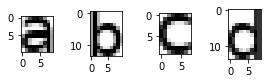

In [9]:
img = imageio.imread("haystack.png")
img = [[x[0] for x in im_row] for im_row in img]

a = [im_row[303:312] for im_row in img[59:69]]
b = [im_row[497:507] for im_row in img[55:69]]
c = [im_row[589:597] for im_row in img[59:69]]
d = [im_row[286:295] for im_row in img[55:69]]

fig, axs = plt.subplots(1, 4, figsize=(4, 4))
fig.tight_layout()
axs[0].imshow(a, cmap='gray')
axs[1].imshow(b, cmap='gray')
axs[2].imshow(c, cmap='gray')
axs[3].imshow(d, cmap='gray')
print("Wybrane wzorce:")
plt.show()

Liczba znalezionych wystąpień wzorca dla litery a: 397, 
Wystąpenia na pozycjach (wiersz, kolumna): [(37, 207), (37, 263), (37, 323), (37, 487), (37, 623), (37, 751), (59, 303), (59, 333), (59, 391), (59, 409), ...]

Liczba znalezionych wystąpień wzorca dla litery b: 56, 
Wystąpenia na pozycjach (wiersz, kolumna): [(33, 694), (55, 497), (77, 26), (143, 37), (143, 460), (143, 538), (143, 560), (209, 316), (253, 284), (275, 26), ...]

Liczba znalezionych wystąpień wzorca dla litery c: 213, 
Wystąpenia na pozycjach (wiersz, kolumna): [(59, 370), (59, 420), (59, 589), (59, 690), (81, 328), (81, 378), (81, 428), (81, 506), (81, 670), (103, 46), ...]

Liczba znalezionych wystąpień wzorca dla litery d: 137, 
Wystąpenia na pozycjach (wiersz, kolumna): [(33, 229), (55, 286), (55, 480), (77, 123), (99, 88), (99, 438), (121, 71), (165, 730), (187, 350), (187, 428), ...]

Znalezione wystąpenia liter a, b, c, d:


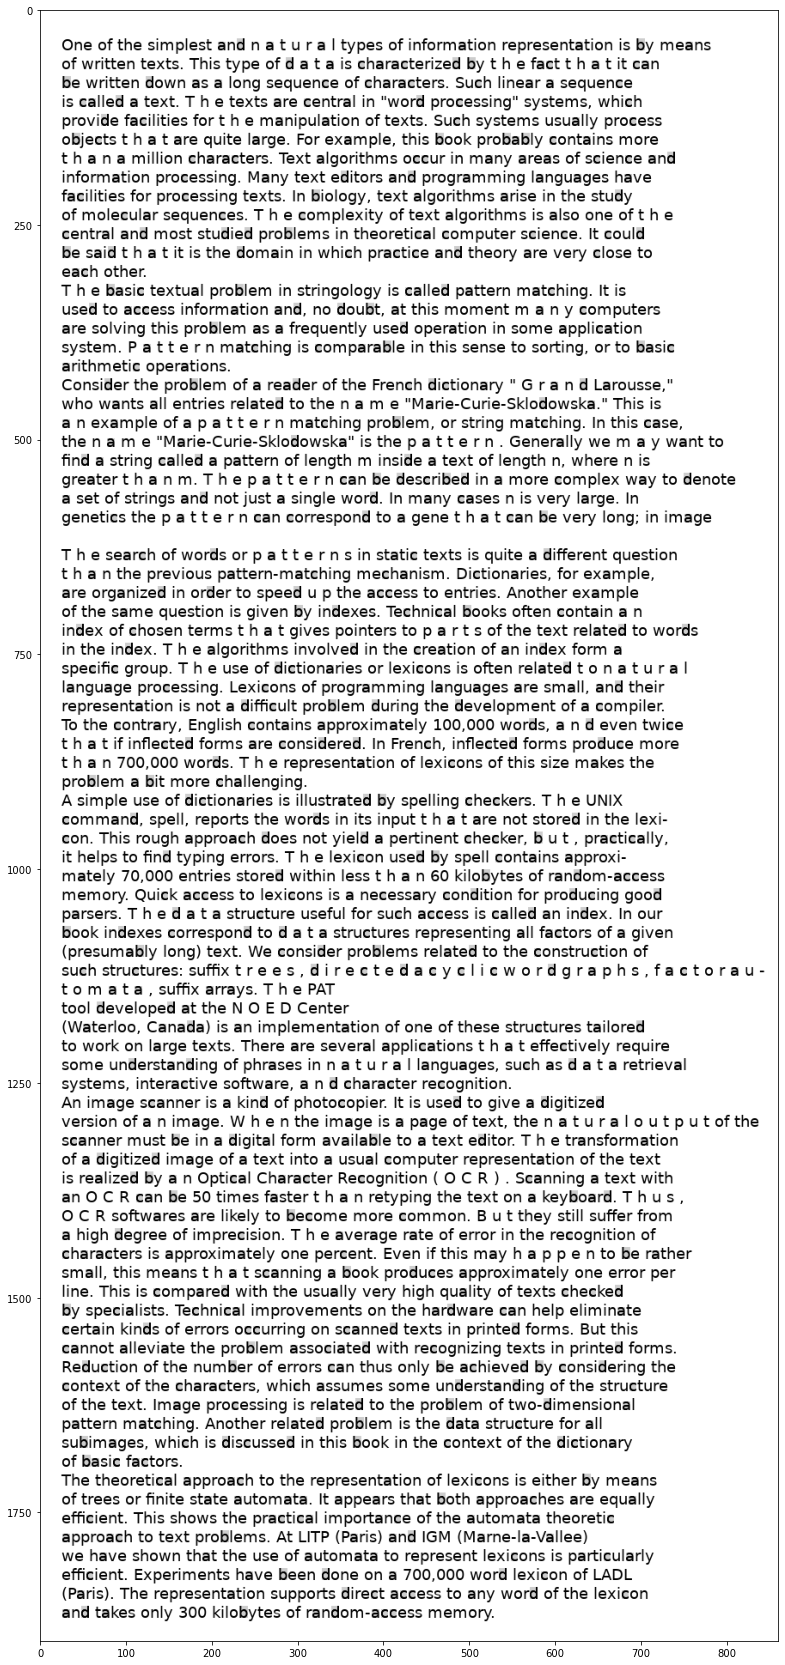

In [10]:
for letter, letter_str in [(a, "a"), (b, "b"), (c, "c"), (d, "d")]:
    results = pattern_matching_2D(img, letter)
    highlight_image_pattern_occurrences(img, letter, results)
    print(f"Liczba znalezionych wystąpień wzorca dla litery {letter_str}: {len(results)}, \n"
          f"Wystąpenia na pozycjach (wiersz, kolumna): {get_list_head_string(results, 10)}\n")


print("Znalezione wystąpenia liter a, b, c, d:")
plt.figure(figsize=(30, 30))
plt.imshow(img, cmap='gray')
plt.show()

# 5. Znajdź wszystkie wystąpienia słowa "p a t t e r n" w haystack.png.

p a t t e r n:


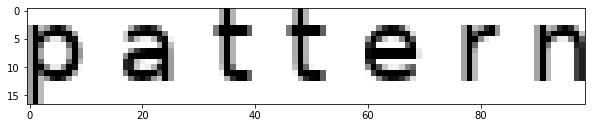

In [11]:
img = imageio.imread("haystack.png")
img = [[x[0] for x in im_row] for im_row in img]

pattern = [im_row[242:341] for im_row in img[540:557]]

print("p a t t e r n:")
plt.figure(figsize=(10, 10))
plt.imshow(pattern, cmap='gray')
plt.show()

Liczba znalezionych wystąpień p a t t e r n u: 5, 
Wystąpenia na pozycjach (wiersz, kolumna): [(474, 184), (496, 428), (540, 242), (584, 142), (628, 248)]

Znalezione wystąpenia p a t t e r n u:


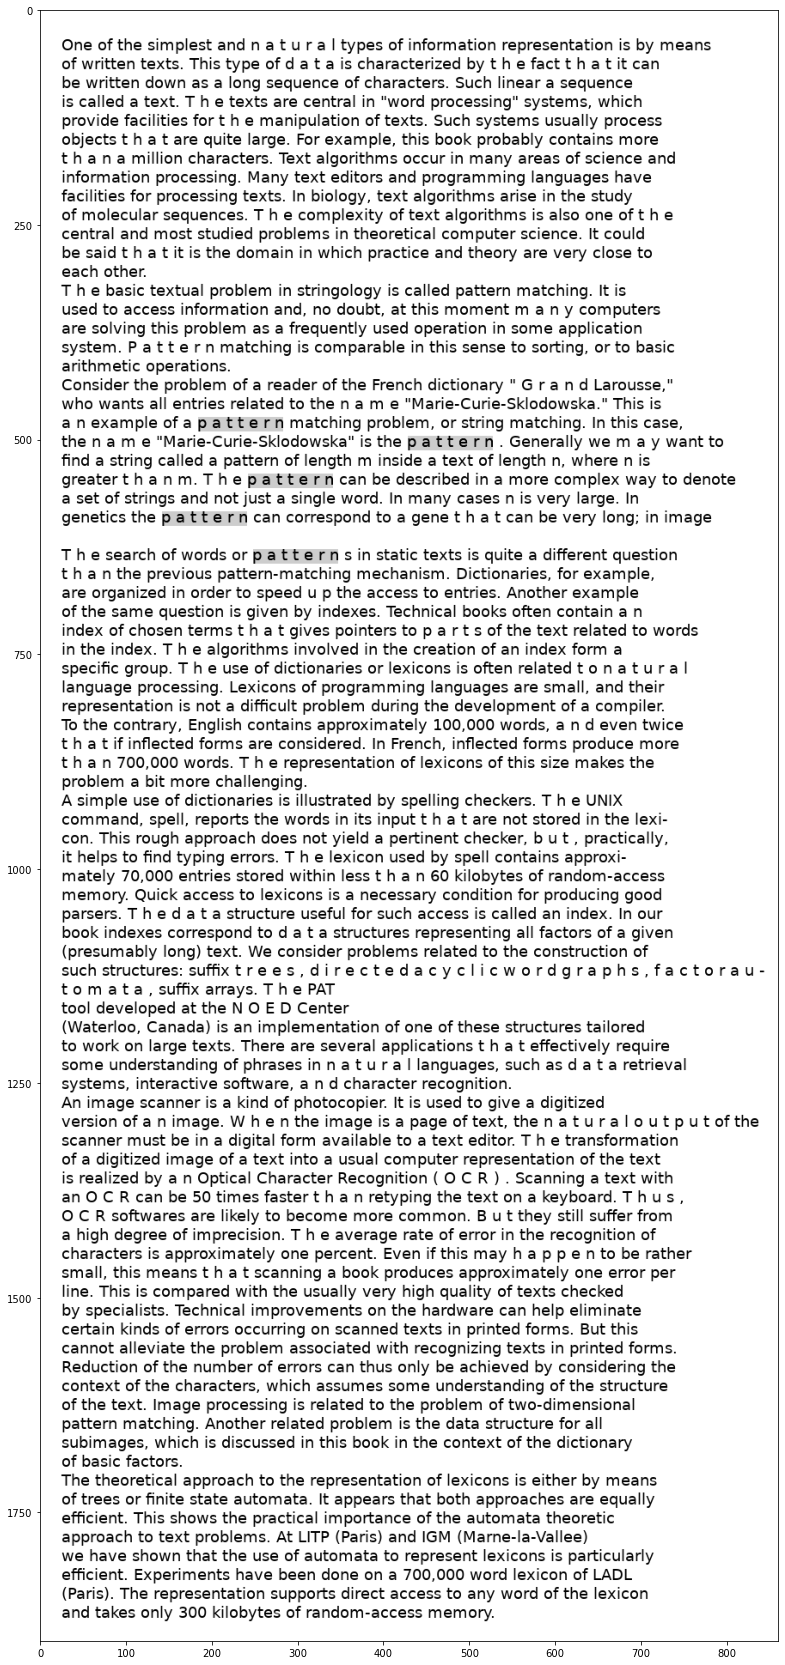

In [12]:
results = pattern_matching_2D(img, pattern)
highlight_image_pattern_occurrences(img, pattern, results)
print(f"Liczba znalezionych wystąpień p a t t e r n u: {len(results)}, \n"
      f"Wystąpenia na pozycjach (wiersz, kolumna): {get_list_head_string(results, 10)}\n")

print("Znalezione wystąpenia p a t t e r n u:")
plt.figure(figsize=(30, 30))
plt.imshow(img, cmap='gray')
plt.show()

# 6. Porównaj czas budowania automatu i czas wyszukiwania dla różnych rozmiarów wzorca

In [13]:
img = imageio.imread("haystack.png")
img = [[x[0] for x in im_row] for im_row in img]

construction_times = []
search_times = []
sizes = [100, 141, 173, 200, 224, 245, 265, 283, 300]

for size in sizes:
    print(f"Długość wzorca (liczba pikseli): {size * size}")
    pattern = [im_row[0:size] for im_row in img[0:size]]
    res, t1, t2 = pattern_matching_2D(img, pattern, return_times=True)
    print(f"Czas budowania automatu: {round(t1, 4)} sek. - Czas wyszukiwania wzorca: {round(t2, 4)} sek.\n")
    construction_times.append(t1)
    search_times.append(t2)

Długość wzorca (liczba pikseli): 10000
Czas budowania automatu: 0.1557 sek. - Czas wyszukiwania wzorca: 0.851 sek.

Długość wzorca (liczba pikseli): 19881
Czas budowania automatu: 0.4303 sek. - Czas wyszukiwania wzorca: 0.6876 sek.

Długość wzorca (liczba pikseli): 29929
Czas budowania automatu: 0.7552 sek. - Czas wyszukiwania wzorca: 0.7128 sek.

Długość wzorca (liczba pikseli): 40000
Czas budowania automatu: 1.039 sek. - Czas wyszukiwania wzorca: 0.7063 sek.

Długość wzorca (liczba pikseli): 50176
Czas budowania automatu: 1.4608 sek. - Czas wyszukiwania wzorca: 0.7926 sek.

Długość wzorca (liczba pikseli): 60025
Czas budowania automatu: 1.7753 sek. - Czas wyszukiwania wzorca: 0.6354 sek.

Długość wzorca (liczba pikseli): 70225
Czas budowania automatu: 2.112 sek. - Czas wyszukiwania wzorca: 0.6379 sek.

Długość wzorca (liczba pikseli): 80089
Czas budowania automatu: 2.6401 sek. - Czas wyszukiwania wzorca: 0.6927 sek.

Długość wzorca (liczba pikseli): 90000
Czas budowania automatu: 2.8

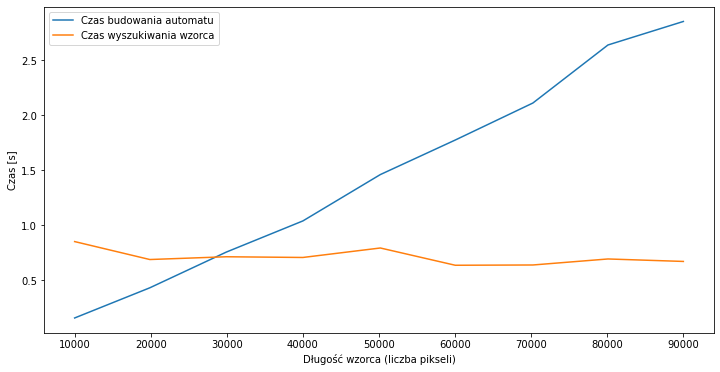

In [14]:
plt.figure(figsize=(12, 6))
plt.plot([x * x for x in sizes], construction_times, label="Czas budowania automatu")
plt.plot([x * x for x in sizes], search_times, label="Czas wyszukiwania wzorca")
plt.legend()
plt.xlabel("Długość wzorca (liczba pikseli)")
plt.ylabel("Czas [s]")
plt.show()

Wnioski:
 - Zgodnie z oczekiwaniami czas budowania automatu rośnie liniowo wraz z długością wzorca.
 - Czas wyszukiwania pozostaje podobny; zależy on od długości tekstu.
 - Dla dłuższych wzorców czas budowania automatu jest dłuższy od samego wyszukiwania, co wynika z faktu, że czas konstruowania tabeli przejścia zależy od długości alfabetu.

# 7. Podziel plik na 2, 4 i 8 fragmentów (w poziomie) i porównaj czas przeszukiwania

In [15]:
img = imageio.imread("haystack.png")
img = [[x[0] for x in im_row] for im_row in img]

pattern_a = [im_row[303:312] for im_row in img[59:69]]

for parts in [2, 4, 8]:
    part_size = len(img) // parts

    img_parts = []
    for i in range(parts):
        img_parts.append(img[i * part_size : (i + 1) * part_size])

    start = time()
    for img_part in img_parts:
        res = pattern_matching_2D(img_part, pattern_a)

    print(f"Liczba fragmentów: {parts}, łączny czas wyszukiwania wzorca: {round(time() - start, 4)} sek.")

Liczba fragmentów: 2, łączny czas wyszukiwania wzorca: 0.5575 sek.
Liczba fragmentów: 4, łączny czas wyszukiwania wzorca: 0.5649 sek.
Liczba fragmentów: 8, łączny czas wyszukiwania wzorca: 0.5332 sek.


Wnioski:
 - Podział na fragmenty nie ma wpływu na długość szukania wzorca.
 - Jeżeli weźmiemy pod uwagę czas konstruowania automatu, to w przypadku dłużych wzorców ogólny czas się wydłuży, ale wystaczy wtedy osobno skonstruować automat i przekazywać go do funkcji wyszukującej wzorzec.